# Walmart Sales forecasting

## importing libraries and loading data

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [319]:
features_df = pd.read_csv('features.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')

## Data cleaning and exploratory analysis

Merging multiple  datasets into single dataset on related columns 

In [320]:
fea_sto_df = features_df.merge(stores_df, how='inner', on='Store')

In [321]:
fea_sto_df.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [322]:
fea_sto_df.Date = pd.to_datetime(fea_sto_df.Date)
train_df.Date = pd.to_datetime(train_df.Date)
test_df.Date = pd.to_datetime(test_df.Date)

In [323]:
fea_sto_df['Week'] = fea_sto_df.Date.dt.week 
fea_sto_df['Year'] = fea_sto_df.Date.dt.year

In [324]:
fea_sto_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Week,Year
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190.000000,8190.000000,8190.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,130287.600000,25.214286,2011.351648
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259,63115.971429,14.527604,1.041762
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000,1.000000,2010.000000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,70713.000000,13.000000,2010.000000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,126512.000000,24.000000,2011.000000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,202307.000000,37.000000,2012.000000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000,52.000000,2013.000000


In [325]:
fea_sto_df.head(100)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,2011-12-02,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False,A,151315,48,2011
96,1,2011-12-09,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False,A,151315,49,2011
97,1,2011-12-16,51.63,3.159,5011.32,67.00,347.37,225.79,4011.37,219.179453,7.866,False,A,151315,50,2011
98,1,2011-12-23,47.96,3.112,2725.36,40.48,634.70,24.90,2739.43,219.357722,7.866,False,A,151315,51,2011


In [326]:
train_detail = train_df.merge(fea_sto_df, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [327]:
test_detail = test_df.merge(fea_sto_df, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [328]:
del features_df, train_df, stores_df, test_df

### Average Sales with respective to store and department

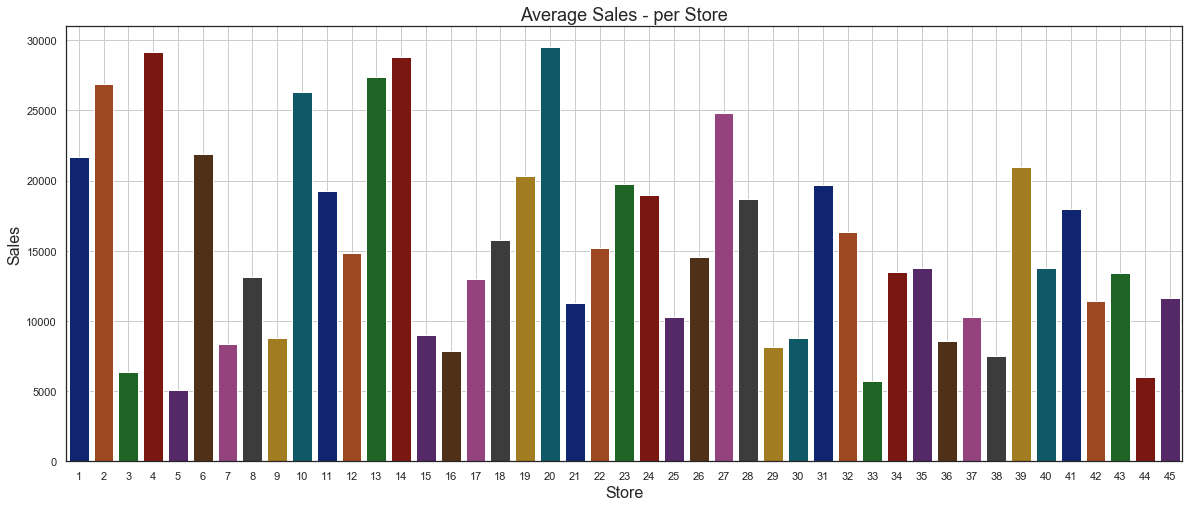

In [345]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sb.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

Above bar graph shows that there is difference in the weekly sales among stores

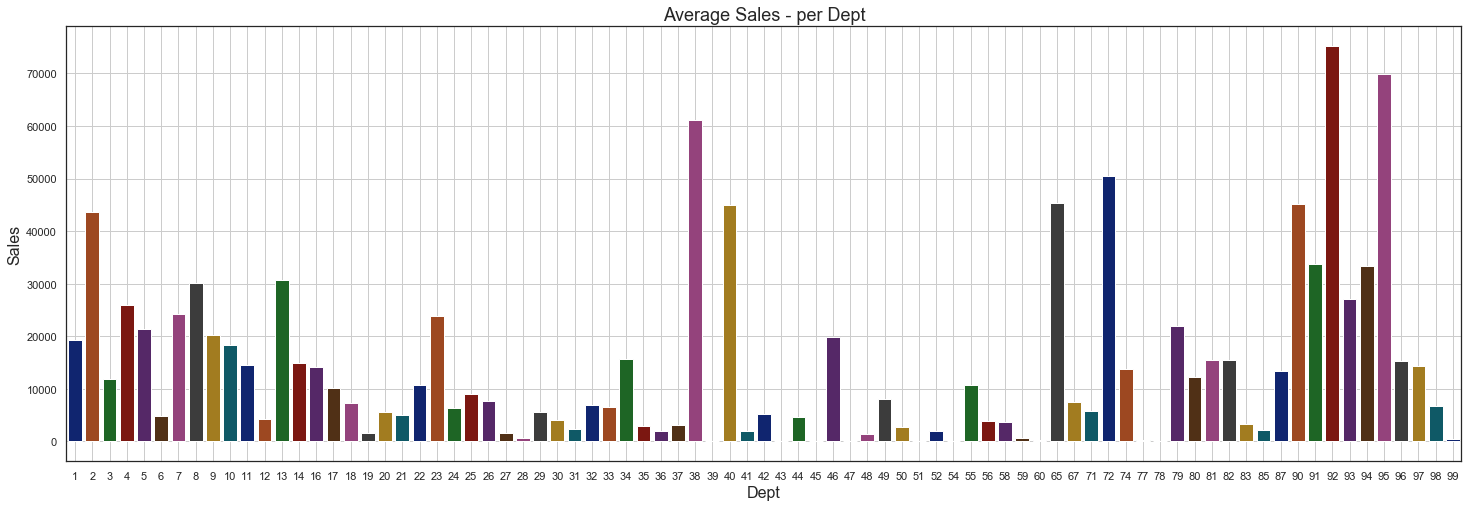

In [346]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sb.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

And above bar graph tells that there is a clear difference between the each department weekly sales



We will check the corelation between the features and dependent varaible

Correlation Metrics:

0: no correlation at all,
0-0.3: weak correlation,
0.3-0.7: moderate correlaton,
0.7-1: strong correlation,

Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.

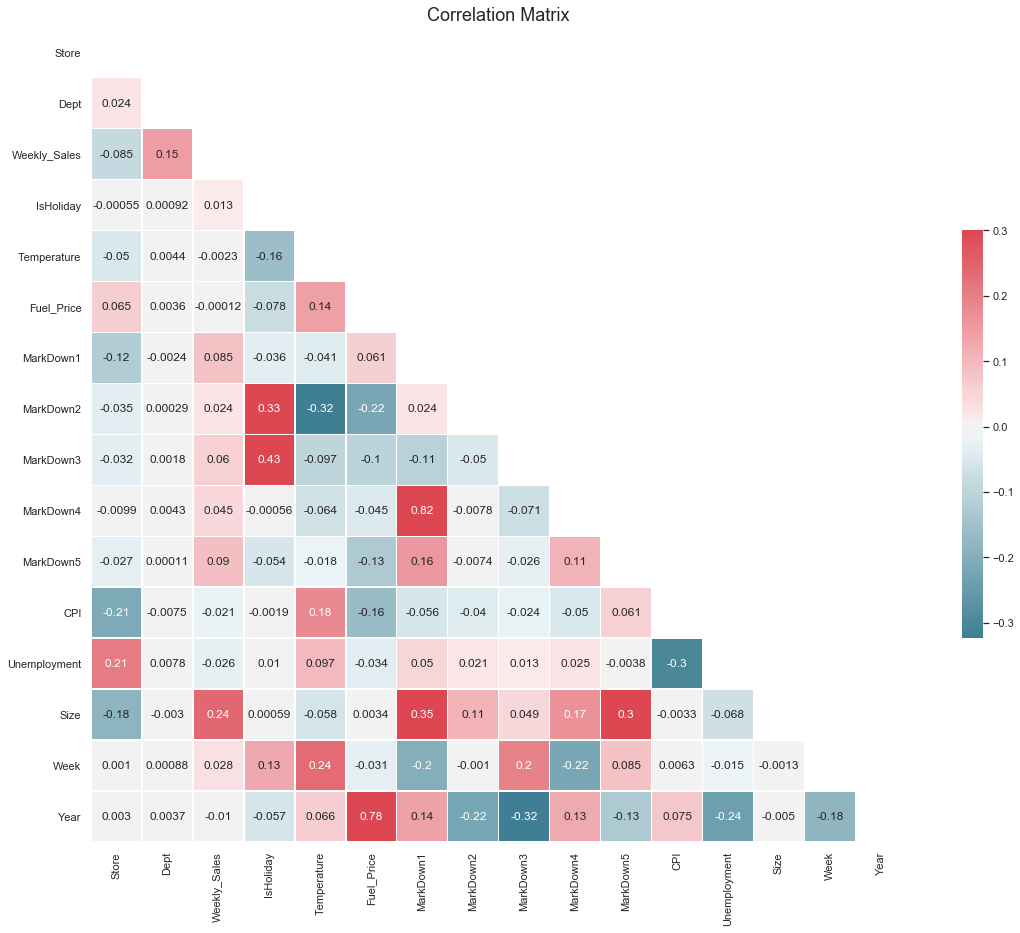

In [329]:
sb.set(style='white')
corr = train_detail.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20,15))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Here, markdown 1 to 5 are weakly co-realted to weekly sales so we will drop those columns 

Also fuel price is strongly co-realted to weekly sales we will drop that one too.

As well as we will drop temparature, CPI, Unemployment as they are nothing to do with prediciting result. 

In [330]:
train_detail = train_detail.drop(columns=['Date','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Temperature'])
test_detail = test_detail.drop(columns=['Date','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Temperature'])

In [331]:
train_detail = pd.get_dummies(train_detail, columns=["Type"])
test_detail = pd.get_dummies(test_detail, columns=["Type"])

## ALgorithms

The list of algorithm where our datasets train on. THese algorithm models the dataset.

In [332]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

In [333]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

## K-Fold Cross Validation

In [334]:
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in train_detail.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

In [335]:
splited

,Store,Dept,Weekly_Sales,IsHoliday,Size,Week,Year,Type_A,Type_B,Type_C,fold
0,1,1,24924.50,False,151315,5,2010,1,0,0,0.0
1,1,1,46039.49,True,151315,6,2010,1,0,0,0.0
2,1,1,41595.55,False,151315,7,2010,1,0,0,0.0
3,1,1,19403.54,False,151315,8,2010,1,0,0,0.0
4,1,1,21827.90,False,151315,9,2010,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
421269,45,98,508.37,False,118221,39,2012,0,1,0,4.0
421270,45,98,628.10,False,118221,40,2012,0,1,0,4.0
421271,45,98,1061.02,False,118221,41,2012,0,1,0,4.0
421272,45,98,760.01,False,118221,42,2012,0,1,0,4.0


### Finding best model for our dataset

In [342]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['Weekly_Sales']
    train_x = dataset_train.drop(columns=['Weekly_Sales', 'fold'])
    test_y = dataset_test['Weekly_Sales']
    test_x = dataset_test.drop(columns=['Weekly_Sales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['IsHoliday'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 11) (85552, 11)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   42.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


0 2092.303049441787
best model
(335849, 11) (85425, 11)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.8s finished


1 2356.998604460581
(335970, 11) (85304, 11)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   42.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


2 1466.5689472204472
best model
(338733, 11) (82541, 11)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


3 3405.8601738500174
(338822, 11) (82452, 11)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


4 1758.28628592249


In [337]:
error_cv

2231.8302965556163

In [338]:
best_error

1483.4776114057504

## Testing Model

In [339]:
predicted_test = best_model.predict(test_detail)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.6s finished


In [340]:
test_detail['weeklySales'] = predicted_test
test_detail['Date'] = column_date
test_detail['id'] = test_detail['Store'].astype(str) + '_' +  test_detail['Dept'].astype(str) + '_' +  test_detail['Date'].astype(str)
test_detail = test_detail[['id', 'weeklySales']]
test_detail = test_detail.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [341]:
test_detail.to_csv('result.csv', index=False)